## for this home work we used drug-classification dataset from kaggle. the goal is to predict which drug is suitable for the patient.
## The target feature is "Drug type"
## And The feature sets are:


*   Age
*   Sex
*   Blood Pressure Levels (BP)
*   Cholesterol Levels
*   Na to Potassium Ratio

## there are five types of drugs so the requierd value for F1-score is above: 2.5/number_of_classes=0.5 but this is a relatively easy dataset and is some cases we reach the total precision of 1.00 (no false prediction is achivable here).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter
import os
import seaborn as sns
import plotly.express as pex
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report as cr
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
!pip install catboost
from catboost import CatBoostClassifier


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [3]:
! kaggle datasets download -d prathamtripathi/drug-classification

drug-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip \*.zip

Archive:  drug-classification.zip
replace drug200.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: drug200.csv             


In [5]:
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


## as you can see 4 columns have categorical data and probably need to be encoded.


In [7]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [8]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

## there isn't any null value.

##now lets visualize some columns


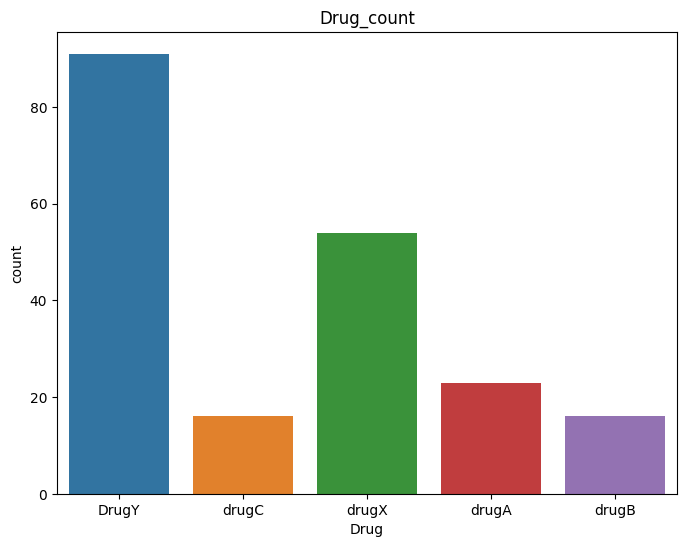

In [9]:
# number of samples with specific type of drug.
plt.figure(figsize=(8, 6))
sns.countplot(df,x='Drug')
plt.title("Drug_count")
plt.show()

## it seems that data is imbalanced and for drugs "Y" and "X" there are plenty of examples.

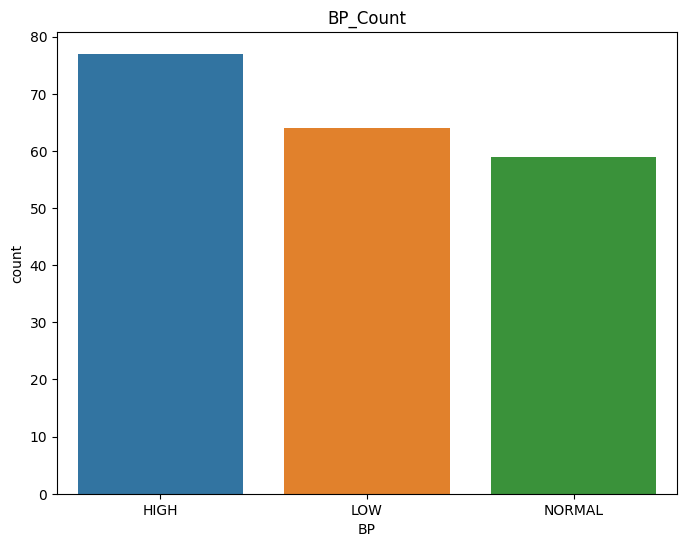

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(df,x='BP')
plt.title("BP_Count")
plt.show()

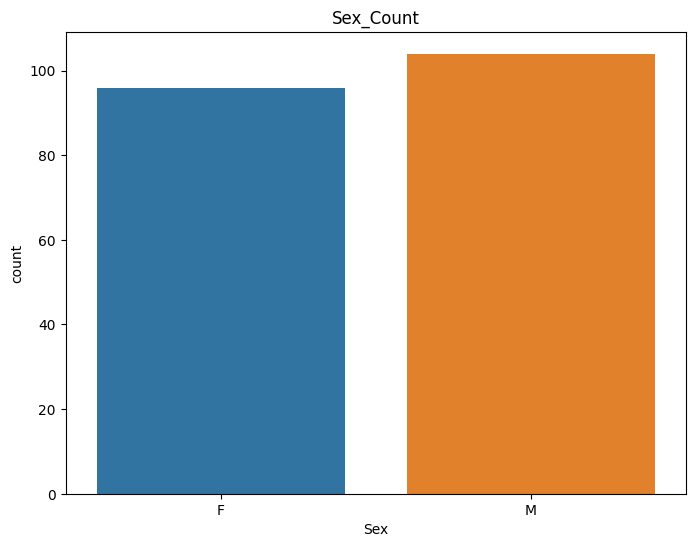

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(df, x='Sex')
plt.title('Sex_Count')
plt.show()

## it seems the samples are distributed almost equally around different sexes and also different blood pressure.

<Figure size 800x600 with 0 Axes>

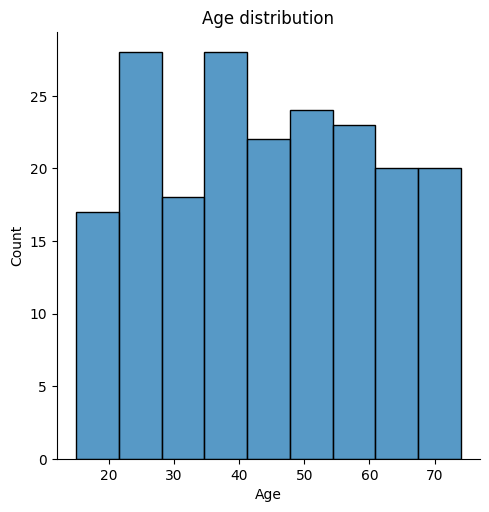

In [12]:
plt.figure(figsize=(8, 6))
sns.displot(df.Age)
plt.title('Age distribution')
plt.show()

## samples are taken fairly from all ages from 20 to under 80's.

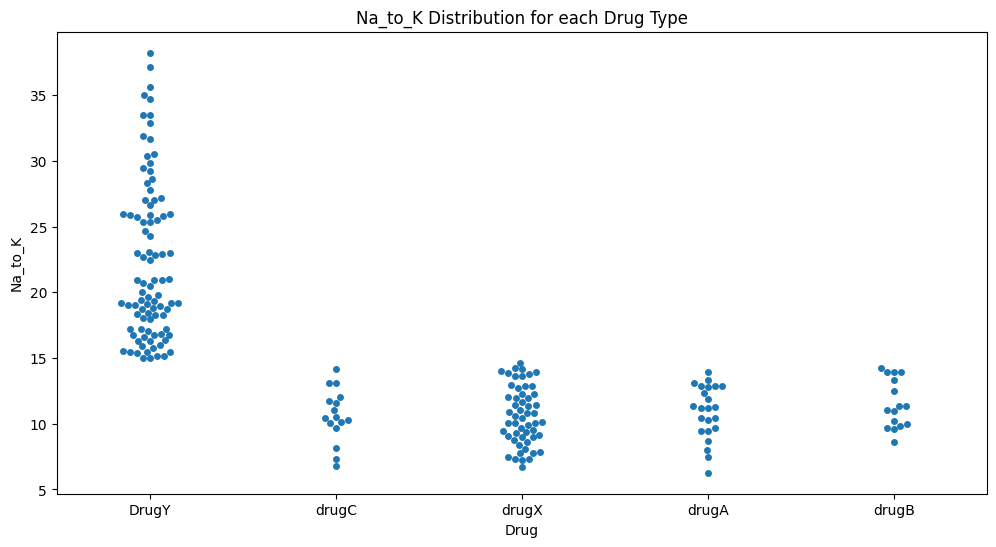

In [13]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='Drug', y='Na_to_K', data=df)
plt.title("Na_to_K Distribution for each Drug Type")
plt.show()

## we can see that based on Na_to_K ration we can decide about using Drug_Y. in general this dataset seem alot like strictly categorical and so the decision tree should yeild a good result.

##first we do some routine tasks like label encoding, train/test split and so on:

In [15]:
# label encoding
label_enc = LabelEncoder()
for i in (['BP', 'Cholesterol', 'Sex', 'Drug']):
  df[i] = label_enc.fit_transform(df[i])

# spliting the target column
correct_labels = df.pop('Drug')

## as we ran below tests, we found that in a lot's of tests we can reach 100% accuracy because the dataset is relatively easy.
## so we set test size to 0.4 of samples to make the task more challenging:


## do normalization and Making train/test split:

In [48]:
# Scaling and Normalization
scaler = StandardScaler()
normalized_df = scaler.fit_transform(df)

# train/test split
x_train, x_test, y_train, y_test = train_test_split(normalized_df, correct_labels, test_size=0.4)

## SVM

In [49]:
from sklearn.svm import SVC
SVC_model = SVC(C=2, kernel='linear', decision_function_shape='ovr', max_iter=1000)
SVC_model.fit(x_train, y_train)
SVC_predicted = SVC_model.predict(x_test)

In [50]:
print(cr(SVC_predicted, y_test))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        36
           1       1.00      0.89      0.94         9
           2       0.75      1.00      0.86         3
           3       0.89      1.00      0.94         8
           4       0.96      0.96      0.96        24

    accuracy                           0.95        80
   macro avg       0.91      0.96      0.93        80
weighted avg       0.95      0.95      0.95        80



## this is totally a good result considering that SVM just sees 60% of samples.

## Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
LR_model_ovr = LogisticRegression(multi_class='ovr')
LR_model_ovr.fit(x_train, y_train)
LR_ovr_predicted = LR_model_ovr.predict(x_test)

In [53]:
print(cr(LR_ovr_predicted, y_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        35
           1       1.00      0.73      0.84        11
           2       0.75      0.75      0.75         4
           3       0.22      1.00      0.36         2
           4       0.96      0.82      0.88        28

    accuracy                           0.85        80
   macro avg       0.77      0.84      0.75        80
weighted avg       0.92      0.85      0.87        80



Logistic Regression yeild smaller F1-scores across all classes.

### Multinomial Logistic Regression

In [54]:
LR_model_multinomial = LogisticRegression(multi_class='multinomial')
LR_model_multinomial.fit(x_train, y_train)
LR_multinomial_predicted = LR_model_multinomial.predict(x_test)

In [55]:
print(cr(LR_multinomial_predicted, y_test))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93        34
           1       1.00      0.73      0.84        11
           2       0.75      0.75      0.75         4
           3       0.56      1.00      0.71         5
           4       1.00      0.92      0.96        26

    accuracy                           0.90        80
   macro avg       0.84      0.87      0.84        80
weighted avg       0.92      0.90      0.90        80



F1-score rises compared to Logistic Regression

In [77]:
# calculating LogLoss
pred_prob = LR_model_multinomial.predict_proba(x_test)
loss = log_loss(y_test, pred_prob)
print('The log_loss of multinomial logistic regression is: {}'.format(loss))

The log_loss of multinomial logistic regression is: 0.35175743862473957


## K Nearest Neighbors

In [59]:
n = range(2, 80)
scores = []
for i in n:
  model = KNeighborsClassifier(n_neighbors=i, weights='distance')
  model.fit(x_train, y_train)
  predict = model.predict(x_test)
  scores.append(f1_score(y_test, predict, average='macro'))

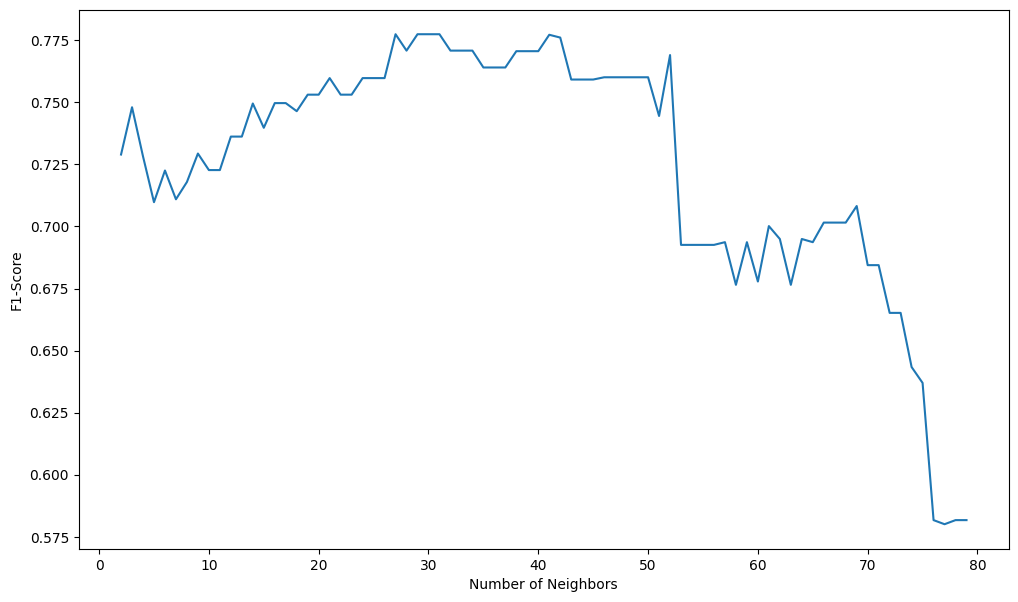

In [61]:
plt.figure(figsize=(12, 7))
plt.plot(n, scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('F1-Score')
plt.show()

## lets take a closer look:

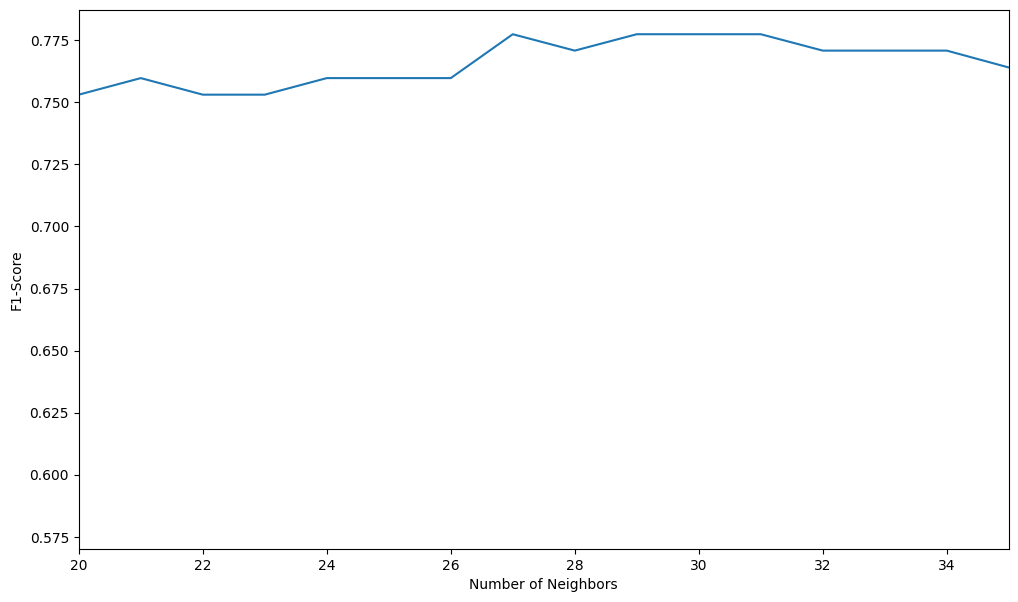

In [62]:
plt.figure(figsize=(12, 7))
plt.plot(n, scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('F1-Score')
plt.xlim(20,35)
plt.show()

## so for KNN, the F1-Score will be maximum when number of neighbors set to 27. this is mostly because our train set is relatively small and the ajgorithm needs to see a lot of neighbours.

In [78]:
KNN_model=KNeighborsClassifier(n_neighbors=27, weights='distance')
KNN_model.fit(x_train, y_train)
KNN_predicted=KNN_model.predict(x_test)

In [79]:
print(cr(KNN_predicted, y_test))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83        37
           1       1.00      0.89      0.94         9
           2       0.75      0.75      0.75         4
           3       0.33      1.00      0.50         3
           4       0.92      0.81      0.86        27

    accuracy                           0.82        80
   macro avg       0.77      0.85      0.78        80
weighted avg       0.87      0.82      0.84        80



## it seems that, so far, class 3 is the hardest class to predict (probably due to low samples)

## Decesion Tree

In [65]:
TREE_model = DecisionTreeClassifier(criterion='gini',max_depth=10)
TREE_model.fit(x_train, y_train)
TREE_predicted = TREE_model.predict(x_test)

In [66]:
print(cr(TREE_predicted, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      0.89      0.94         9
           2       0.75      1.00      0.86         3
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        24

    accuracy                           0.99        80
   macro avg       0.95      0.98      0.96        80
weighted avg       0.99      0.99      0.99        80



## decision tree is doing great! even for class 3.

## XGBoost

## for these algorithms we make their work even harder:

In [119]:
x_train, x_test, y_train, y_test = train_test_split(normalized_df, correct_labels, test_size=0.6)

In [122]:
XGB_model = XGBClassifier(n_estimators=50)
XGB_model.fit(x_train, y_train,eval_metric=f1_score)
XGB_predicted = XGB_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [124]:
print(cr(XGB_predicted, y_test))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        56
           1       0.93      0.93      0.93        14
           2       1.00      0.92      0.96        12
           3       1.00      0.78      0.88         9
           4       1.00      0.97      0.98        29

    accuracy                           0.96       120
   macro avg       0.97      0.92      0.94       120
weighted avg       0.96      0.96      0.96       120



## xgboost scores are still good. lets do grid search:

In [132]:
from sklearn.model_selection import RandomizedSearchCV
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "eta": [0.1, 0.01],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2,5,10,15,20,30],
    "n_estimators": [10,20,30,50,100],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.3,0.6,0.7,0.8,0.9,1],
}

n_iter=50
grid = RandomizedSearchCV(
    estimator=XGB_model,
    param_distributions=param_grid,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model = grid.fit(x_train,y_train)

CPU times: user 810 ms, sys: 21.2 ms, total: 831 ms
Wall time: 11.7 s


In [133]:
XGB_best_predicted = best_model.predict(x_test)
predictions = best_model.predict(x_test)
print(cr(predictions, y_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        58
           1       0.93      0.93      0.93        14
           2       1.00      0.92      0.96        12
           3       0.86      1.00      0.92         6
           4       1.00      0.93      0.97        30

    accuracy                           0.97       120
   macro avg       0.95      0.96      0.95       120
weighted avg       0.97      0.97      0.97       120



In [134]:
print('subsample is: %d ' %best_model.best_estimator_.subsample)
print('depth is: %d ' %best_model.best_estimator_.max_depth)
print('n_estimators is: %.2f '  %best_model.best_estimator_.n_estimators)
print('colsample_bytree is: %.2f '  %best_model.best_estimator_.colsample_bytree)
print('Gamma is: %.2f '  %best_model.best_estimator_.gamma)

subsample is: 0 
depth is: 30 
n_estimators is: 50.00 
colsample_bytree is: 1.00 
Gamma is: 0.60 


## with searching, the weighted average raises by 2%.

<Axes: title={'center': 'Feature Weight'}, xlabel='F score', ylabel='Features'>

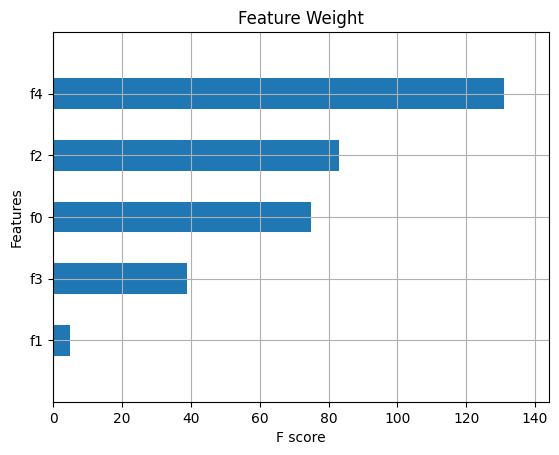

In [135]:
plot_importance(
    booster=XGB_model,
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
)

<Axes: title={'center': 'Split Mean Gain'}, xlabel='F score', ylabel='Features'>

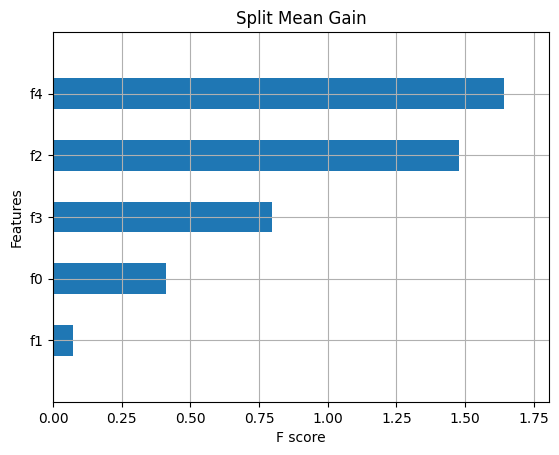

In [136]:
plot_importance(
    booster=XGB_model,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
)

<Axes: title={'center': 'Sample Coverage'}, xlabel='F score', ylabel='Features'>

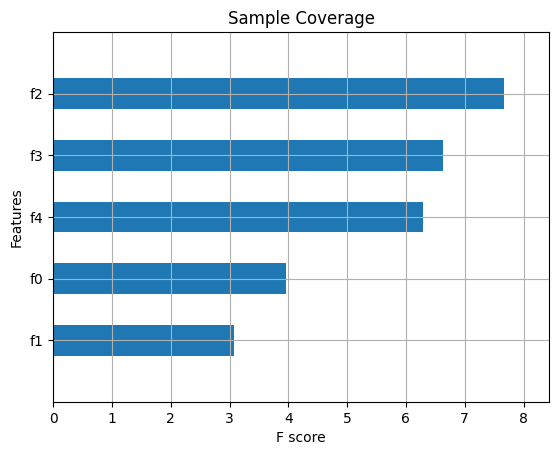

In [137]:
plot_importance(
    XGB_model,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
)

## it seems that f2 and f4 are more important both in sample coverage and feature importance.

## Light GBM

In [ ]:
LGB_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=10)
LGB_model.fit(x_train,y_train)
LGB_predicted = LGB_model.predict(x_test)

In [139]:
print(cr(LGB_predicted, y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        55
           1       0.93      0.87      0.90        15
           2       1.00      0.85      0.92        13
           3       1.00      1.00      1.00         7
           4       1.00      0.93      0.97        30

    accuracy                           0.95       120
   macro avg       0.97      0.93      0.95       120
weighted avg       0.95      0.95      0.95       120



## light gbm also doing great as expected.

## CatBoost

In [140]:
CBC_model = CatBoostClassifier(learning_rate=.05, iterations=200, verbose=False)
CBC_model.fit(x_train, y_train)
CBC_predicted = CBC_model.predict(x_test)

In [141]:
print(cr(CBC_predicted, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00        28

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



## it was anticipated that catboost act very good in this categorical dataset.

## Question: explain how KNN and decision trees can be extended to multi-label classification problems.

## Answer:
there are different ways for doing this. but the simplest ones are:


1.   treat each label as a binary classification problem and at the end finally assign all predicted labels that come from seperate KNN or decision trees.
2.   Treat each combination of labels as a unique class and Convert the multi-label problem into a multi-class problem.
3.   Modify the distance metric to consider the correlation between labels.

of course there are other sophisticated way for doing this. one example is to Use ensemble methods like Random Forests or Gradient Boosted Trees and Train multiple decision trees, each focusing on a subset of labels and finally Combine the results to make predictions for multiple labels

